<a href="https://colab.research.google.com/github/SVJLucas/DeepLense/blob/main/training_and_compare_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install vit-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.3 MB/s eta 0:00:00


In [2]:
!pip install SciencePlots

# Importing libraries

In [3]:
import os
import torch
import numpy as np
from torch import nn
from torch import Tensor
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from typing import Tuple, Union, List
from sklearn.metrics import accuracy_score
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from PIL import Image
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee','no-latex'])

# Opening Dataset (Real-Galaxy-tiny)

In [4]:
def load_numpy_array_from_path(path):
    """
    Load a numpy array from the given path.

    Args:
        path (str): The path from where the numpy array should be loaded.

    Returns:
        numpy.ndarray: Loaded numpy array.
    """
    return np.load(path)

In [5]:
data_path = PATH TO THE FOLDER OF THE Real-Galaxy-Tiny DATASET

In [6]:
X_train = load_numpy_array_from_path(f'{data_path}/data_train.npy')
y_train = load_numpy_array_from_path(f'{data_path}/labels_train.npy')
X_test = load_numpy_array_from_path(f'{data_path}/data_test.npy')
y_test = load_numpy_array_from_path(f'{data_path}/labels_test.npy')

In [7]:
print(f'The number of train samples is: {len(X_train)}.')
print(f'The number of test samples is: {len(X_test)}.')

The number of train samples is: 1000.
The number of test samples is: 1000.


In [8]:
def get_loader_from_dataset(X: np.ndarray, y: np.ndarray, batch_size: int) -> DataLoader:

    """

    Creates a DataLoader object from numpy arrays containing images and labels.

    Args:
        X (np.ndarray): numpy array containing the images.
        y (np.ndarray): numpy array containing the labels.
        batch_size (int): size of the batches to use in the DataLoader.

    Returns:
        DataLoader: the created DataLoader object.

    """


    X = torch.Tensor(np.array(X).reshape(len(X),1,64,64))
    y = torch.Tensor(np.array(y))

    # create a TensorDataset object with the tensors and a DataLoader object with the dataset
    dataset = TensorDataset(X,y)
    loader = DataLoader(dataset, batch_size=batch_size,shuffle=True)
    return loader

In [9]:
train_loader = get_loader_from_dataset(X_train,y_train,batch_size=64)
test_loader = get_loader_from_dataset(X_test,y_test,batch_size=64)

# Defining Training Function

In [10]:
from sklearn.metrics import f1_score
def plot_model_metrics(mean_loss_train,mean_f1_train):
    """
    Plots the training loss and ROC-AUC over epochs.

    Args:
        mean_loss_train (list): List of mean training loss over epochs.
        mean_auc_train (list): List of mean training ROC-AUC over epochs.

    Returns:
        None
    """
    # Plot training and testing loss over epochs
    plt.figure()
    plt.plot(mean_loss_train, label='Train')
    plt.title('Loss - Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(mean_f1_train, label='Train')
    plt.title('F1 - Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1')
    plt.legend()
    plt.show()

    print('\n\n')


def train_final_model(model,total_training_loader,total_test_loader,n_epochs,optimizer,criterion,device):

    """

    Trains a PyTorch model.

    Args:

    - model (nn.Module): the PyTorch model to be trained
    - train_loader (DataLoader): DataLoader containing the training set
    - n_epochs (int): number of training epochs
    - optimizer (optim.Optimizer): the optimizer to use for training
    - criterion (nn.Module): the loss function to use for training
    - device (str): device to run the model on (e.g. 'cpu' or 'cuda')

    Returns:

    - mean_loss_train (list): mean loss per epoch for the training set
    - mean_auc_train (list): mean ROC-AUC per epoch for the test set


    """

    # initialize lists to keep track of metrics
    mean_loss_train = []
    mean_f1_train = []
    mean_loss_test = []
    mean_f1_test = []

    # loop over epochs
    for it in range(n_epochs):

        # initialize list to keep track of train loss for this epoch
        train_loss = []
        train_f1 = []

        # set model to train mode
        model.train()

        # loop over training data
        for images, targets in total_training_loader:
            # move data to device
            images, targets = images.to(device), targets.to(device)

            # zero the gradients
            optimizer.zero_grad()

            # forward pass
            outputs = model(images)

            # compute loss
            loss = criterion(outputs, targets)

            # backward pass and optimization step
            loss.backward()
            optimizer.step()

            # append loss to train_loss list
            train_loss.append(loss.item())

            # ROC Score
            preds = outputs.detach().cpu().numpy()
            labels = targets.detach().cpu().numpy()


            preds = [np.argmax(pred) for pred in preds]
            labels = [np.argmax(label) for label in labels]
            train_f1.append(f1_score(labels,preds,average='micro'))

        # initialize list to keep track of train loss for this epoch
        test_loss = []
        test_f1 = []

        # set model to train mode
        model.eval()

        # turn off gradients for evaluation
        with torch.no_grad():

          # loop over training data
          for images, targets in total_test_loader:
              # move data to device
              images, targets = images.to(device), targets.to(device)

              # forward pass
              outputs = model(images)

              # compute loss
              loss = criterion(outputs, targets)

              # append loss to train_loss list
              test_loss.append(loss.item())

              # ROC Score
              preds = outputs.detach().cpu().numpy()
              labels = targets.detach().cpu().numpy()


              preds = [np.argmax(pred) for pred in preds]
              labels = [np.argmax(label) for label in labels]
              test_f1.append(f1_score(labels,preds,average='micro'))

        # append the mean train loss for this epoch to the list of train losses
        mean_loss_train.append(np.mean(train_loss))
        mean_f1_train.append(np.mean(train_f1))
        mean_loss_test.append(np.mean(test_loss))
        mean_f1_test.append(np.mean(test_f1))


        # print epoch metrics
        print(f'Epoch {it}/{n_epochs}, Train Loss: {mean_loss_train[-1]:.4f}, Train F1: {mean_f1_train[-1]:.4f},Test Loss: {mean_loss_test[-1]:.4f}, Test F1: {mean_f1_test[-1]:.4f}, ')


    # return lists of mean train
    return mean_loss_train,mean_f1_train,mean_loss_test,mean_f1_test

# Training Models

Funtion to know the quantity of parameters in each model:

In [11]:
def count_parameters(model: nn.Module) -> int:
    """
    Count the total number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model for which to count the parameters.

    Returns:
        int: The total number of trainable parameters in the model.

    """
    # Count the number of trainable parameters
    num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Finding the value in M
    num_parameters = num_parameters/1e6

    print(f"The model has {num_parameters:.2f}M trainable parameters.")

    return num_parameters

Function to save the performance of each model

In [12]:
import json
from typing import List
from sklearn.metrics import accuracy_score, roc_curve

def save_lists_to_file(file_path: str, num_parameters: float, mean_loss_train: List[float], mean_f1_train: List[float], mean_loss_test: List[float], mean_f1_test: List[float], y_test_true: List[int], y_pred_prob: List[float]) -> None:
    """
    Saves the given lists, model size, ROC curve data, and calculated accuracy to a JSON file with their respective names.

    Args:
        file_path (str): The path where the JSON file will be saved.
        num_parameters (float): The number of parameters of the model (in Mega (1e6)).
        mean_loss_train (List[float]): List containing mean loss values for training.
        mean_f1_train (List[float]): List containing mean F1 scores for training.
        mean_loss_test (List[float]): List containing mean loss values for testing.
        mean_f1_test (List[float]): List containing mean F1 scores for testing.
        y_test_true (List[int]): List containing true labels for testing.
        y_pred_prob (List[float]): List containing predicted probabilities.

    Returns:
        None

    Raises:
        IOError: Raises an exception if the file cannot be written.
    """

    # Calculate the false positive rate and true positive rate using roc_curve
    fpr, tpr, _ = roc_curve(y_test_true, y_pred_prob)

    # Calculate accuracy using scikit-learn's accuracy_score function
    accuracy = accuracy_score(y_test_true, [1 if prob >= 0.5 else 0 for prob in y_pred_prob])

    # Create a dictionary to hold list names, their values, model size, ROC curve data, and calculated accuracy
    data_dict = {
        'model_size': num_parameters,
        'num_epochs': len(mean_loss_train),
        'mean_loss_train': mean_loss_train,
        'mean_f1_train': mean_f1_train,
        'mean_loss_test': mean_loss_test,
        'mean_f1_test': mean_f1_test,
        'y_test_true': y_test_true,
        'y_pred_prob': y_pred_prob,
        'fpr': fpr.tolist(),  # Convert numpy array to list
        'tpr': tpr.tolist(),  # Convert numpy array to list
        'accuracy': accuracy
    }

    try:
        # Open a file in write mode
        with open(file_path, 'w') as f:
            # Write the dictionary to the file as a JSON object
            json.dump(data_dict, f, indent=4)
    except IOError:
        print("An error occurred while writing the file.")


Defining save folders path:

In [13]:
results_folder = '/../results/results'
weights_folder = '/../results/weights'

## ViT

### Model Declaration




In [14]:
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

### Model Training

In [15]:
vit = ViT(
    image_size = 64,
    patch_size = 32,
    num_classes = 2,
    dim = 1024,
    depth = 2,
    heads = 24,
    mlp_dim = 16,
    dropout = 0.1,
    channels = 1,
    emb_dropout = 0.1,
    pool = 'cls'
)

In [16]:
count_parameters(vit)

The model has 13.72M trainable parameters.


13.724706

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(vit.parameters(),lr=5e-7)

In [18]:
vit.to(device)

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-1): 2 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.1, inplace=False)
          (to_qkv): Linear(in_features=1024, out_features=4608, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=1536, out_features=1024, bias=True)
            (1): Dropout(p=0.1, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
     

In [19]:
mean_loss_train_vit,mean_f1_train_vit,mean_loss_test_vit,mean_f1_test_vit = train_final_model(vit,train_loader,test_loader,n_epochs=3000,optimizer=optimizer,criterion=criterion,device=device)

Epoch 0/3000, Train Loss: 0.7387, Train F1: 0.4977,Test Loss: 0.7342, Test F1: 0.5000, 
Epoch 1/3000, Train Loss: 0.7334, Train F1: 0.5062,Test Loss: 0.7188, Test F1: 0.4994, 
Epoch 2/3000, Train Loss: 0.7134, Train F1: 0.5164,Test Loss: 0.7063, Test F1: 0.5023, 
Epoch 3/3000, Train Loss: 0.7051, Train F1: 0.5297,Test Loss: 0.6991, Test F1: 0.5018, 
Epoch 4/3000, Train Loss: 0.7035, Train F1: 0.5053,Test Loss: 0.6938, Test F1: 0.5039, 
Epoch 5/3000, Train Loss: 0.7133, Train F1: 0.4930,Test Loss: 0.6898, Test F1: 0.5312, 
Epoch 6/3000, Train Loss: 0.6978, Train F1: 0.5289,Test Loss: 0.6868, Test F1: 0.5674, 
Epoch 7/3000, Train Loss: 0.7001, Train F1: 0.5221,Test Loss: 0.6841, Test F1: 0.5818, 
Epoch 8/3000, Train Loss: 0.6870, Train F1: 0.5563,Test Loss: 0.6819, Test F1: 0.5785, 
Epoch 9/3000, Train Loss: 0.6889, Train F1: 0.5410,Test Loss: 0.6792, Test F1: 0.5855, 
Epoch 10/3000, Train Loss: 0.6880, Train F1: 0.5510,Test Loss: 0.6774, Test F1: 0.5879, 
Epoch 11/3000, Train Loss: 0.68

 Saving results:

In [55]:
json_path  = os.path.join(results_folder,'vit.json')
model_path  = os.path.join(weights_folder,'vit.pth')

# Prepare for ROC-AUC curve tanking the role test dataset
final_test_loader = get_loader_from_dataset(X_test, y_test, batch_size=1000)

for images, target in final_test_loader:
    images, target = images.to(device), target.to(device)
    break

vit.eval()
output = vit(images)
y_pred_onehot = output.detach().cpu().numpy()
y_true_onehot = target.detach().cpu().numpy()

# Convert one-hot encoding to label format
y_test_true_vit = np.argmax(y_true_onehot, axis=1)

# Get the predicted probabilities for the positive class
y_pred_prob_vit = y_pred_onehot[:, 1]

# Converting to Numpy
y_test_true_vit = y_test_true_vit.tolist()
y_pred_prob_vit = y_pred_prob_vit.tolist()


num_parameters = count_parameters(vit)
save_lists_to_file(json_path, num_parameters, mean_loss_train_vit, mean_f1_train_vit, mean_loss_test_vit, mean_f1_test_vit, y_test_true_vit, y_pred_prob_vit)
torch.save(vit.state_dict(), model_path)

The model has 13.72M trainable parameters.


## CaiT

### Model Declaration

In [60]:
from random import randrange
import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# file adapted from: https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/cait.py
# helpers


def exists(val):
    return val is not None


def dropout_layers(layers, dropout):
    if dropout == 0:
        return layers

    num_layers = len(layers)
    to_drop = torch.zeros(num_layers).uniform_(0.0, 1.0) < dropout

    # make sure at least one layer makes it
    if all(to_drop):
        rand_index = randrange(num_layers)
        to_drop[rand_index] = False

    layers = [layer for (layer, drop) in zip(layers, to_drop) if not drop]
    return layers


# classes


class LayerScale(nn.Module):
    def __init__(self, dim, fn, depth):
        super().__init__()
        if depth <= 18:  # epsilon detailed in section 2 of paper
            init_eps = 0.1
        elif depth > 18 and depth <= 24:
            init_eps = 1e-5
        else:
            init_eps = 1e-6

        scale = torch.zeros(1, 1, dim).fill_(init_eps)
        self.scale = nn.Parameter(scale)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) * self.scale


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.0):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_q = nn.Linear(dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias=False)

        self.attend = nn.Softmax(dim=-1)

        self.mix_heads_pre_attn = nn.Parameter(torch.randn(heads, heads))
        self.mix_heads_post_attn = nn.Parameter(torch.randn(heads, heads))

        self.to_out = nn.Sequential(nn.Linear(inner_dim, dim), nn.Dropout(dropout))

    def forward(self, x, context=None):
        b, n, _, h = *x.shape, self.heads

        context = x if not exists(context) else torch.cat((x, context), dim=1)

        qkv = (self.to_q(x), *self.to_kv(context).chunk(2, dim=-1))
        q, k, v = map(lambda t: rearrange(t, "b n (h d) -> b h n d", h=h), qkv)

        dots = einsum("b h i d, b h j d -> b h i j", q, k) * self.scale

        dots = einsum(
            "b h i j, h g -> b g i j", dots, self.mix_heads_pre_attn
        )  # talking heads, pre-softmax
        attn = self.attend(dots)
        attn = einsum(
            "b h i j, h g -> b g i j", attn, self.mix_heads_post_attn
        )  # talking heads, post-softmax

        out = einsum("b h i j, b h j d -> b h i d", attn, v)
        out = rearrange(out, "b h n d -> b n (h d)")
        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(
        self, dim, depth, heads, dim_head, mlp_dim, dropout=0.0, layer_dropout=0.0
    ):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.layer_dropout = layer_dropout

        for ind in range(depth):
            self.layers.append(
                nn.ModuleList(
                    [
                        LayerScale(
                            dim,
                            PreNorm(
                                dim,
                                Attention(
                                    dim, heads=heads, dim_head=dim_head, dropout=dropout
                                ),
                            ),
                            depth=ind + 1,
                        ),
                        LayerScale(
                            dim,
                            PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout)),
                            depth=ind + 1,
                        ),
                    ]
                )
            )

    def forward(self, x, context=None):
        layers = dropout_layers(self.layers, dropout=self.layer_dropout)

        for attn, ff in layers:
            x = attn(x, context=context) + x
            x = ff(x) + x
        return x


class CaiT(nn.Module):
    def __init__(
        self,
        *,
        image_size,
        patch_size,
        num_classes,
        dim,
        depth,
        cls_depth,
        heads,
        mlp_dim,
        dim_head=64,
        dropout=0.0,
        emb_dropout=0.0,
        layer_dropout=0.0,
        channels=3
    ):
        super().__init__()
        assert (
            image_size % patch_size == 0
        ), "Image dimensions must be divisible by the patch size."
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.to_patch_embedding = nn.Sequential(
            Rearrange(
                "b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1=patch_size, p2=patch_size
            ),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        self.dropout = nn.Dropout(emb_dropout)

        self.patch_transformer = Transformer(
            dim, depth, heads, dim_head, mlp_dim, dropout, layer_dropout
        )
        self.cls_transformer = Transformer(
            dim, cls_depth, heads, dim_head, mlp_dim, dropout, layer_dropout
        )

        self.mlp_head = nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim, num_classes))

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        x += self.pos_embedding[:, :n]
        x = self.dropout(x)

        x = self.patch_transformer(x)

        cls_tokens = repeat(self.cls_token, "() n d -> b n d", b=b)
        x = self.cls_transformer(cls_tokens, context=x)

        return self.mlp_head(x[:, 0])

### Model Training

In [61]:
cait = CaiT(
    image_size = 64,
    patch_size = 32,
    num_classes = 2,
    channels = 1,
    dim = 1024,
    depth = 2,             # depth of transformer for patch to patch attention only
    cls_depth = 1,          # depth of cross attention of CLS tokens to patch
    heads = 16,
    mlp_dim = 16,
    dropout = 0.1,
    emb_dropout = 0.1,
    layer_dropout = 0.05    # randomly dropout 5% of the layers
)

In [62]:
count_parameters(cait)

The model has 13.77M trainable parameters.


13.766194

In [63]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(cait.parameters(),lr=5e-7)

In [64]:
cait.to(device)

CaiT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (patch_transformer): Transformer(
    (layers): ModuleList(
      (0-1): 2 x ModuleList(
        (0): LayerScale(
          (fn): PreNorm(
            (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (to_q): Linear(in_features=1024, out_features=1024, bias=False)
              (to_kv): Linear(in_features=1024, out_features=2048, bias=False)
              (attend): Softmax(dim=-1)
              (to_out): Sequential(
                (0): Linear(in_features=1024, out_features=1024, bias=True)
                (1): Dropout(p=0.1, inplace=False)
              )
            )
          )
        )
        (1): LayerScale(
          (fn): PreNorm(
            (norm): LayerNorm((1024,), eps=1e-05, elementwise_aff

In [65]:
mean_loss_train_cait,mean_f1_train_cait,mean_loss_test_cait,mean_f1_test_cait = train_final_model(cait,train_loader,test_loader,n_epochs=3000,optimizer=optimizer,criterion=criterion,device=device)

Epoch 0/3000, Train Loss: 0.7299, Train F1: 0.4988,Test Loss: 0.7243, Test F1: 0.4982, 
Epoch 1/3000, Train Loss: 0.7208, Train F1: 0.4971,Test Loss: 0.7166, Test F1: 0.4977, 
Epoch 2/3000, Train Loss: 0.7121, Train F1: 0.5006,Test Loss: 0.7092, Test F1: 0.4988, 
Epoch 3/3000, Train Loss: 0.7069, Train F1: 0.4965,Test Loss: 0.7035, Test F1: 0.4988, 
Epoch 4/3000, Train Loss: 0.7029, Train F1: 0.5018,Test Loss: 0.6994, Test F1: 0.4994, 
Epoch 5/3000, Train Loss: 0.6983, Train F1: 0.5000,Test Loss: 0.6966, Test F1: 0.5012, 
Epoch 6/3000, Train Loss: 0.6959, Train F1: 0.5033,Test Loss: 0.6950, Test F1: 0.5012, 
Epoch 7/3000, Train Loss: 0.6950, Train F1: 0.4971,Test Loss: 0.6942, Test F1: 0.4994, 
Epoch 8/3000, Train Loss: 0.6950, Train F1: 0.4990,Test Loss: 0.6939, Test F1: 0.5006, 
Epoch 9/3000, Train Loss: 0.6941, Train F1: 0.5109,Test Loss: 0.6933, Test F1: 0.4994, 
Epoch 10/3000, Train Loss: 0.6943, Train F1: 0.5117,Test Loss: 0.6935, Test F1: 0.5061, 
Epoch 11/3000, Train Loss: 0.69

In [66]:
json_path  = os.path.join(results_folder,'cait.json')
model_path  = os.path.join(weights_folder,'cait.pth')

# Prepare for ROC-AUC curve tanking the role test dataset
final_test_loader = get_loader_from_dataset(X_test, y_test, batch_size=1000)

for images, target in final_test_loader:
    images, target = images.to(device), target.to(device)
    break
cait.eval()
output = cait(images)
y_pred_onehot = output.detach().cpu().numpy()
y_true_onehot = target.detach().cpu().numpy()

# Convert one-hot encoding to label format
y_test_true_cait = np.argmax(y_true_onehot, axis=1)

# Get the predicted probabilities for the positive class
y_pred_prob_cait = y_pred_onehot[:, 1]

# Converting to Numpy
y_test_true_cait = y_test_true_cait.tolist()
y_pred_prob_cait = y_pred_prob_cait.tolist()

num_parameters = count_parameters(cait)
save_lists_to_file(json_path, num_parameters, mean_loss_train_cait, mean_f1_train_cait, mean_loss_test_cait, mean_f1_test_cait, y_test_true_cait, y_pred_prob_cait)
torch.save(cait.state_dict(), model_path)

The model has 13.77M trainable parameters.


## CvT

### Model Declaration

In [47]:


# file adapted from: https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/cvt.py
# helper methods


def group_dict_by_key(cond, d):
    return_val = [dict(), dict()]
    for key in d.keys():
        match = bool(cond(key))
        ind = int(not match)
        return_val[ind][key] = d[key]
    return (*return_val,)


def group_by_key_prefix_and_remove_prefix(prefix, d):
    kwargs_with_prefix, kwargs = group_dict_by_key(lambda x: x.startswith(prefix), d)
    kwargs_without_prefix = dict(
        map(lambda x: (x[0][len(prefix) :], x[1]), tuple(kwargs_with_prefix.items()))
    )
    return kwargs_without_prefix, kwargs


# classes


class LayerNorm(nn.Module):  # layernorm, but done in the channel dimension #1
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))
        self.b = nn.Parameter(torch.zeros(1, dim, 1, 1))

    def forward(self, x):
        var = torch.var(x, dim=1, unbiased=False, keepdim=True)
        mean = torch.mean(x, dim=1, keepdim=True)
        return (x - mean) / (var + self.eps).sqrt() * self.g + self.b


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        x = self.norm(x)
        return self.fn(x, **kwargs)


class FeedForwardCvT(nn.Module):
    def __init__(self, dim, mult=4, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim, dim * mult, 1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(dim * mult, dim, 1),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class DepthWiseConv2d(nn.Module):
    def __init__(self, dim_in, dim_out, kernel_size, padding, stride, bias=True):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                dim_in,
                dim_in,
                kernel_size=kernel_size,
                padding=padding,
                groups=dim_in,
                stride=stride,
                bias=bias,
            ),
            nn.BatchNorm2d(dim_in),
            nn.Conv2d(dim_in, dim_out, kernel_size=1, bias=bias),
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(
        self, dim, proj_kernel, kv_proj_stride, heads=8, dim_head=64, dropout=0.0
    ):
        super().__init__()
        inner_dim = dim_head * heads
        padding = proj_kernel // 2
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)

        self.to_q = DepthWiseConv2d(
            dim, inner_dim, proj_kernel, padding=padding, stride=1, bias=False
        )
        self.to_kv = DepthWiseConv2d(
            dim,
            inner_dim * 2,
            proj_kernel,
            padding=padding,
            stride=kv_proj_stride,
            bias=False,
        )

        self.to_out = nn.Sequential(nn.Conv2d(inner_dim, dim, 1), nn.Dropout(dropout))

    def forward(self, x):
        shape = x.shape
        b, n, _, y, h = *shape, self.heads
        q, k, v = (self.to_q(x), *self.to_kv(x).chunk(2, dim=1))
        q, k, v = map(
            lambda t: rearrange(t, "b (h d) x y -> (b h) (x y) d", h=h), (q, k, v)
        )

        dots = einsum("b i d, b j d -> b i j", q, k) * self.scale

        attn = self.attend(dots)

        out = einsum("b i j, b j d -> b i d", attn, v)
        out = rearrange(out, "(b h) (x y) d -> b (h d) x y", h=h, y=y)
        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(
        self,
        dim,
        proj_kernel,
        kv_proj_stride,
        depth,
        heads,
        dim_head=64,
        mlp_mult=4,
        dropout=0.0,
    ):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(
                nn.ModuleList(
                    [
                        PreNorm(
                            dim,
                            Attention(
                                dim,
                                proj_kernel=proj_kernel,
                                kv_proj_stride=kv_proj_stride,
                                heads=heads,
                                dim_head=dim_head,
                                dropout=dropout,
                            ),
                        ),
                        PreNorm(dim, FeedForwardCvT(dim, mlp_mult, dropout=dropout)),
                    ]
                )
            )

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class CvT(nn.Module):
    def __init__(
        self,
        *,
        channels,
        num_classes,
        s1_emb_dim=64,
        s1_emb_kernel=7,
        s1_emb_stride=4,
        s1_proj_kernel=3,
        s1_kv_proj_stride=2,
        s1_heads=1,
        s1_depth=1,
        s1_mlp_mult=4,
        s2_emb_dim=192,
        s2_emb_kernel=3,
        s2_emb_stride=2,
        s2_proj_kernel=3,
        s2_kv_proj_stride=2,
        s2_heads=3,
        s2_depth=2,
        s2_mlp_mult=4,
        mlp_last=192,
        dropout=0.0,
    ):
        super().__init__()
        kwargs = dict(locals())

        dim = channels
        layers = []

        for prefix in ("s1", "s2"):
            config, kwargs = group_by_key_prefix_and_remove_prefix(f"{prefix}_", kwargs)

            layers.append(
                nn.Sequential(
                    nn.Conv2d(
                        dim,
                        config["emb_dim"],
                        kernel_size=config["emb_kernel"],
                        padding=(config["emb_kernel"] // 2),
                        stride=config["emb_stride"],
                    ),
                    LayerNorm(config["emb_dim"]),
                    Transformer(
                        dim=config["emb_dim"],
                        proj_kernel=config["proj_kernel"],
                        kv_proj_stride=config["kv_proj_stride"],
                        depth=config["depth"],
                        heads=config["heads"],
                        mlp_mult=config["mlp_mult"],
                        dropout=dropout,
                    ),
                )
            )

            dim = config["emb_dim"]

        self.layers = nn.Sequential(
            *layers,
            nn.AdaptiveAvgPool2d(1),
            Rearrange("... () () -> ..."),
            nn.Linear(dim, mlp_last),
            nn.BatchNorm1d(mlp_last),
            nn.ELU(inplace=True),
            nn.Linear(mlp_last, num_classes),
        )

    def forward(self, x):
        return self.layers(x)




### Training Model

In [48]:
cvt = CvT(num_classes = 2,
          channels = 1,
          s1_emb_dim = 1024,        # stage 1 - dimension
          s1_emb_kernel = 7,      # stage 1 - conv kernel
          s1_emb_stride = 4,      # stage 1 - conv stride
          s1_proj_kernel = 3,     # stage 1 - attention ds-conv kernel size
          s1_kv_proj_stride = 2,  # stage 1 - attention key / value projection stride
          s1_heads = 8,           # stage 1 - heads
          s1_depth = 1,           # stage 1 - depth
          s1_mlp_mult = 4,        # stage 1 - feedforward expansion factor
          s2_emb_dim = 256,       # stage 2 - (same as above)
          s2_emb_kernel = 3,
          s2_emb_stride = 2,
          s2_proj_kernel = 3,
          s2_kv_proj_stride = 2,
          s2_heads = 4,
          s2_depth = 1,
          s2_mlp_mult = 4,
          dropout = 0.1)

In [49]:
count_parameters(cvt)

The model has 13.78M trainable parameters.


13.776578

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(cvt.parameters(),lr=5e-7)

In [51]:
cvt.to(device)

CvT(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 1024, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (1): LayerNorm()
      (2): Transformer(
        (layers): ModuleList(
          (0): ModuleList(
            (0): PreNorm(
              (norm): LayerNorm()
              (fn): Attention(
                (attend): Softmax(dim=-1)
                (to_q): DepthWiseConv2d(
                  (net): Sequential(
                    (0): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1024, bias=False)
                    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                    (2): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
                  )
                )
                (to_kv): DepthWiseConv2d(
                  (net): Sequential(
                    (0): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=1024, bias=False)
   

In [52]:
mean_loss_train_cvt,mean_f1_train_cvt,mean_loss_test_cvt,mean_f1_test_cvt = train_final_model(cvt,train_loader,test_loader,n_epochs=3000,optimizer=optimizer,criterion=criterion,device=device)

Epoch 0/3000, Train Loss: 0.7326, Train F1: 0.5105,Test Loss: 0.6929, Test F1: 0.5012, 
Epoch 1/3000, Train Loss: 0.6910, Train F1: 0.5492,Test Loss: 0.6844, Test F1: 0.5740, 
Epoch 2/3000, Train Loss: 0.6717, Train F1: 0.5674,Test Loss: 0.6749, Test F1: 0.5789, 
Epoch 3/3000, Train Loss: 0.6563, Train F1: 0.6090,Test Loss: 0.6759, Test F1: 0.5822, 
Epoch 4/3000, Train Loss: 0.6450, Train F1: 0.6029,Test Loss: 0.6815, Test F1: 0.5705, 
Epoch 5/3000, Train Loss: 0.6438, Train F1: 0.6125,Test Loss: 0.6748, Test F1: 0.5898, 
Epoch 6/3000, Train Loss: 0.6387, Train F1: 0.6197,Test Loss: 0.6525, Test F1: 0.5938, 
Epoch 7/3000, Train Loss: 0.6285, Train F1: 0.6354,Test Loss: 0.6531, Test F1: 0.6000, 
Epoch 8/3000, Train Loss: 0.6333, Train F1: 0.6395,Test Loss: 0.6631, Test F1: 0.6010, 
Epoch 9/3000, Train Loss: 0.6274, Train F1: 0.6309,Test Loss: 0.6461, Test F1: 0.6105, 
Epoch 10/3000, Train Loss: 0.6159, Train F1: 0.6645,Test Loss: 0.6496, Test F1: 0.6072, 
Epoch 11/3000, Train Loss: 0.62

In [53]:
json_path  = os.path.join(results_folder,'cvt.json')
model_path  = os.path.join(weights_folder,'cvt.pth')

# Prepare for ROC-AUC curve tanking the role test dataset
final_test_loader = get_loader_from_dataset(X_test, y_test, batch_size=1000)

for images, target in final_test_loader:
    images, target = images.to(device), target.to(device)
    break

cvt.eval()
output = cvt(images)
y_pred_onehot = output.detach().cpu().numpy()
y_true_onehot = target.detach().cpu().numpy()

# Convert one-hot encoding to label format
y_test_true_cvt = np.argmax(y_true_onehot, axis=1)

# Get the predicted probabilities for the positive class
y_pred_prob_cvt = y_pred_onehot[:, 1]

# Converting to Numpy
y_test_true_cvt = y_test_true_cvt.tolist()
y_pred_prob_cvt = y_pred_prob_cvt.tolist()


num_parameters = count_parameters(cvt)
save_lists_to_file(json_path, num_parameters, mean_loss_train_cvt, mean_f1_train_cvt, mean_loss_test_cvt, mean_f1_test_cvt, y_test_true_cvt, y_pred_prob_cvt)
torch.save(cvt.state_dict(), model_path)

The model has 13.78M trainable parameters.


# ViTSD

### Model Declaration

In [69]:
from math import sqrt
import torch
import torch.nn.functional as F
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class LSA(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.temperature = nn.Parameter(torch.log(torch.tensor(dim_head ** -0.5)))

        self.norm = nn.LayerNorm(dim)
        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.norm(x)
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.temperature.exp()

        mask = torch.eye(dots.shape[-1], device = dots.device, dtype = torch.bool)
        mask_value = -torch.finfo(dots.dtype).max
        dots = dots.masked_fill(mask, mask_value)

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                LSA(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class SPT(nn.Module):
    def __init__(self, *, dim, patch_size, channels = 3):
        super().__init__()
        patch_dim = patch_size * patch_size * 5 * channels

        self.to_patch_tokens = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim)
        )

    def forward(self, x):
        shifts = ((1, -1, 0, 0), (-1, 1, 0, 0), (0, 0, 1, -1), (0, 0, -1, 1))
        shifted_x = list(map(lambda shift: F.pad(x, shift), shifts))
        x_with_shifts = torch.cat((x, *shifted_x), dim = 1)
        return self.to_patch_tokens(x_with_shifts)

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = SPT(dim = dim, patch_size = patch_size, channels = channels)

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

### Model Training

In [72]:
vitsd = ViT(image_size=64,
            patch_size=32,
            num_classes=2,
            dim=1024,
            depth=2,
            heads=16,
            mlp_dim=16,
            channels = 1,
            dropout = 0.1,
            emb_dropout = 0.1)

In [73]:
count_parameters(vitsd)

The model has 13.73M trainable parameters.


13.730852

In [74]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(vitsd.parameters(),lr=5e-7)

In [75]:
vitsd.to(device)

ViT(
  (to_patch_embedding): SPT(
    (to_patch_tokens): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
      (1): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=5120, out_features=1024, bias=True)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-1): 2 x ModuleList(
        (0): LSA(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.1, inplace=False)
          (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
            (1): Dropout(p=0.1, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_fea

In [76]:
mean_loss_train_vitsd,mean_f1_train_vitsd,mean_loss_test_vitsd,mean_f1_test_vitsd = train_final_model(vitsd,train_loader,test_loader,n_epochs=3000,optimizer=optimizer,criterion=criterion,device=device)

Epoch 0/3000, Train Loss: 0.7080, Train F1: 0.4846,Test Loss: 0.6881, Test F1: 0.5070, 
Epoch 1/3000, Train Loss: 0.6982, Train F1: 0.5270,Test Loss: 0.6818, Test F1: 0.5891, 
Epoch 2/3000, Train Loss: 0.6903, Train F1: 0.5465,Test Loss: 0.6772, Test F1: 0.6148, 
Epoch 3/3000, Train Loss: 0.6899, Train F1: 0.5375,Test Loss: 0.6737, Test F1: 0.6180, 
Epoch 4/3000, Train Loss: 0.6885, Train F1: 0.5520,Test Loss: 0.6701, Test F1: 0.6262, 
Epoch 5/3000, Train Loss: 0.6754, Train F1: 0.5955,Test Loss: 0.6673, Test F1: 0.6277, 
Epoch 6/3000, Train Loss: 0.6744, Train F1: 0.5824,Test Loss: 0.6637, Test F1: 0.6318, 
Epoch 7/3000, Train Loss: 0.6699, Train F1: 0.5713,Test Loss: 0.6622, Test F1: 0.6217, 
Epoch 8/3000, Train Loss: 0.6700, Train F1: 0.5883,Test Loss: 0.6588, Test F1: 0.6189, 
Epoch 9/3000, Train Loss: 0.6754, Train F1: 0.5705,Test Loss: 0.6570, Test F1: 0.6199, 
Epoch 10/3000, Train Loss: 0.6652, Train F1: 0.5887,Test Loss: 0.6550, Test F1: 0.6236, 
Epoch 11/3000, Train Loss: 0.66

In [77]:
json_path  = os.path.join(results_folder,'vitsd.json')
model_path  = os.path.join(weights_folder,'vitsd.pth')

# Prepare for ROC-AUC curve tanking the role test dataset
final_test_loader = get_loader_from_dataset(X_test, y_test, batch_size=1000)

for images, target in final_test_loader:
    images, target = images.to(device), target.to(device)
    break

vitsd.eval()
output = vitsd(images)
y_pred_onehot = output.detach().cpu().numpy()
y_true_onehot = target.detach().cpu().numpy()

# Convert one-hot encoding to label format
y_test_true_vitsd = np.argmax(y_true_onehot, axis=1)

# Get the predicted probabilities for the positive class
y_pred_prob_vitsd = y_pred_onehot[:, 1]

# Converting to Numpy
y_test_true_vitsd = y_test_true_vitsd.tolist()
y_pred_prob_vitsd = y_pred_prob_vitsd.tolist()


num_parameters = count_parameters(vitsd)
save_lists_to_file(json_path, num_parameters, mean_loss_train_vitsd, mean_f1_train_vitsd, mean_loss_test_vitsd, mean_f1_test_vitsd, y_test_true_vitsd, y_pred_prob_vitsd)
torch.save(vitsd.state_dict(), model_path)

The model has 13.73M trainable parameters.


# Lensformer

### Declaring Model

#### Flatten

In [26]:
class Flatten(nn.Module):
    """
    This module flattens the input tensor into a 2D tensor with a fixed
    number of neurons (elements) in the second dimension.

    Args:
        num_neurons_flatten (int): Number of neurons to flatten the input tensor to.

    Attributes:
        num_neurons_flatten (int): Number of neurons to flatten the input tensor to.

    Returns:
        Flattened tensor with shape `[batch_size, num_neurons_flatten]`.
    """

    def __init__(self, num_neurons_flatten: int):
        # Initialize the superclass
        super(Flatten, self).__init__()
        self.num_neurons_flatten = num_neurons_flatten

    def forward(self, x: Tensor) -> Tensor:
        # Flatten the tensor to the specified number of neurons
        return x.contiguous().view(-1, self.num_neurons_flatten)


#### Feedforward

In [27]:
class FeedForward(nn.Module):

  def __init__(self,
               in_features: int,
               out_features: int,
               activation_function: nn.Module,
               num_hidden_neurons: int,
               num_hidden_layers: int,
               task_type: str,
               dropout: float = 0.1,):
    """

    Initializes a FeedForward neural network.
    The FeedForward class is a neural network module in PyTorch that represents a multi-layer
    feedforward neural network. The class takes as input the number of input features, output
    features, activation function, number of hidden neurons, number of hidden layers, and
    dropout rate. It initializes a list of PyTorch modules that defines the layers of the neural
    network, with a linear layer, activation function, and dropout layer for the first layer,
    and a sequence of linear, activation, and dropout layers for the subsequent hidden layers.
    The final layer is a linear layer followed by an activation function choosen by the task_type
    argument (Identity function if task_type='regression', Sigmoid if task_type='binary_classification'
    or Softmax if task_type='multi_classification'). The forward method of the class takes an input
    tensor and applies each layer in the list of PyTorch modules in sequence to produce an output
    tensor, which represents the output of the feedforward neural network.

    Args:
      -in_features (int): number of input features.
      -out_features (int): number of output features.
      -activation_function (nn.Module): activation function to be used in hidden layers.
      -final_activation_function (nn.Module): activation function to be used in final layer (depends on the task).
      -num_hidden_neurons (int): number of neurons in each hidden layer.
      -num_hidden_layers (int): number of hidden layers in the network.
      -task_type (str): Task to be solved by the neural network. Must be one of: 'regression', 'binary_classification' or 'multi_classification'.
      -dropout (float, optional): dropout probability. Defaults to 0.1.

    Attributes:
      -feedforward (nn.ModuleList): List with each layer of the neural network.

    """

    super(FeedForward,self).__init__()
    self.feedforward = nn.ModuleList()

    # add input layer
    self.feedforward.append(nn.Linear(in_features,num_hidden_neurons))
    self.feedforward.append(activation_function())
    self.feedforward.append(nn.Dropout(dropout))

    # add hidden layers
    for _ in range(num_hidden_layers):
      self.feedforward.append(nn.Linear(num_hidden_neurons,num_hidden_neurons))
      self.feedforward.append(activation_function())
      self.feedforward.append(nn.Dropout(dropout))

    if task_type=='regression':

      self.final_activation_function = nn.Identity()

    elif task_type=='binary_classification':

      self.final_activation_function = nn.Sigmoid()

      if out_features != 1:
        raise ValueError("task_type='binary_classification' only supports 1 neuron on the end of the neural network (out_features = 1). If you want to use more than one neuron, use 'multi_classification' instead.")

    elif task_type=='multi_classification':

      self.final_activation_function = nn.Softmax(dim=1)

    else:
      raise ValueError("task_type must be either of 'regression','binary_classification' or 'multi_classification'.")

    # add output layer
    self.feedforward.append(nn.Linear(num_hidden_neurons,out_features))
    self.feedforward.append(self.final_activation_function)

  def forward(self,x: Tensor)->Tensor:

    """

    Computes the forward pass of the feedforward neural network.
    Args:
       x (Tensor): input tensor of shape [batch_size, in_features]
    Returns:
       Tensor: output tensor of shape [batch_size, out_features]

    """

    for layer in self.feedforward:
      x = layer(x)
    return x

#### ShiftedPatchTokenization (SPT)

In [28]:
class ShiftedPatchTokenization(nn.Module):

    """

    This module performs shifted patch tokenization on input images,
    generating patches with positional encodings for use in transformer models.

    Attributes:
        embed_dim (int): The dimension of the output embedding.
        image_width (int): Width of the input image.
        image_height (int): Height of the input image.
        patch_width (int): Width of each patch.
        patch_height (int): Height of each patch.
        device (torch.device): The device to use for computation.
        num_patches (int): The total number of patches generated from an image.
        delta_x (int): The amount to shift along the x-axis.
        delta_y (int): The amount to shift along the y-axis.
        total_channels (int): The total number of channels in the output tensor.
        projection (nn.Conv2d): Conv2D layer for patch projection.
        layer_norm (nn.LayerNorm): Layer normalization.
        cls_token (nn.Parameter): Token for class.
        positional_encoding (nn.Parameter): Positional encoding for patches.

    """

    def __init__(self, image_size: Union[int,Tuple[int,int]],
                 patch_size: Union[int,Tuple[int,int]], embed_dim: int,
                 in_channels: int, device: torch.device):

        """
        Initializes the ShiftedPatchTokenization module.

        Args:
            image_size (Union[int, Tuple[int, int]]): Size of the input image. If an integer, it is assumed to be square-shaped.
            patch_size (Union[int, Tuple[int, int]]): Size of each patch. If an integer, it is assumed to be square-shaped.
            embed_dim (int): Dimension of the output embedding.
            in_channels (int): Number of channels in the input image.
            device (torch.device): Device to use for computation.

        Raises:
            ValueError: If the image dimensions are not divisible by the patch dimensions.
        """

        super(ShiftedPatchTokenization, self).__init__()

        # If image_size or patch_size is an integer, convert it to a tuple with equal width and height
        if type(image_size) == int:
            image_size = (image_size, image_size)
        if type(patch_size) == int:
            patch_size = (patch_size, patch_size)

        self.embed_dim = embed_dim
        self.image_width, self.image_height = image_size
        self.patch_width, self.patch_height = patch_size
        self.device = device

        # Check if the image dimensions are divisible by the patch dimensions
        if self.image_width % self.patch_width != 0 or self.image_height % self.patch_height != 0:
            raise ValueError("The image's width must be divisible by the patche's width and the image's height, by the patch's height")

        # Calculate the number of patches
        self.num_patches = int((self.image_width // self.patch_width) * (self.image_height // self.patch_height))

        # Set the translation amounts
        self.delta_x = self.patch_width // 2
        self.delta_y = self.patch_height // 2

        # Set the total number of channels for the output tensor
        self.num_transformations = 4
        self.total_channels = in_channels * (self.num_transformations + 1)

        # Define the projection layer
        self.projection = nn.Conv2d(in_channels=self.total_channels,
                                    out_channels=self.embed_dim,
                                    kernel_size=(self.patch_width, self.patch_height),
                                    stride=(self.patch_width, self.patch_height))

        # Define the layer normalization layer
        self.layer_norm = nn.LayerNorm(self.embed_dim)

        # Define the CLS token
        self.cls_token = nn.Parameter(torch.zeros((1, 1, self.embed_dim)))

        # Define the positional encoding
        self.positional_encoding = nn.Parameter(torch.zeros((1, 1 + self.num_patches, self.embed_dim)))

    def translate_image(self, image: Tensor, delta_x: int, delta_y: int, device: torch.device):

        """
        Translates an image by specified amounts along the x and y axes.

        Args:
            image (Tensor): Input image tensor.
            delta_x (int): Shift amount along the x-axis.
            delta_y (int): Shift amount along the y-axis.
            device (torch.device): Device to use for computation.

        Returns:
            Tensor: Translated image.
        """

        translated_image = transforms.functional.affine(image, angle=0, translate=(delta_x, delta_y), fill=0, scale=1, shear=0)
        translated_image = translated_image.to(device)
        return translated_image

    def get_num_patches(self):

        """
        Gets the total number of patches that would be created from an image.

        Returns:
            int: The total number of patches.
        """

        return self.num_patches

    def forward(self, image: Tensor) -> Tensor:

        """
        Performs the forward pass, tokenizing the image into patches and adding positional encodings.

        Args:
            image (Tensor): A tensor representing an image, of shape (batch_size, in_channels, image_height, image_width).

        Returns:
            Tensor: A tensor of tokenized image patches, of shape (batch_size, num_patches+1, embed_dim).
        """

        batch_size = image.size(0)


        # generate shifted versions of the image
        shift_left_up = self.translate_image(image, -self.delta_x, -self.delta_y,self.device)
        shift_right_up = self.translate_image(image, self.delta_x, -self.delta_y,self.device)
        shift_left_down = self.translate_image(image, -self.delta_x, self.delta_y,self.device)
        shift_right_down = self.translate_image(image, self.delta_x, self.delta_y,self.device)

        # concatenate the original image with its shifted versions
        concatenated_images = torch.cat((image, shift_left_up, shift_right_up, shift_left_down, shift_right_down), dim=1)

        # project the concatenated image onto a lower-dimensional embedding
        projected_patches = self.projection(concatenated_images)
        patches = projected_patches.flatten(2)
        patches = patches.transpose(1, 2)

        patches.to(self.device)

        # apply layer normalization to the patches
        patches = self.layer_norm(patches)

        # append a learnable "class token" to the beginning of the patch sequence
        cls = self.cls_token.expand(batch_size, -1, -1)
        patches = torch.cat((cls, patches), dim=1)

        patches.to(self.device)

        # add learnable positional encodings to the patches
        patches = patches + self.positional_encoding

        return patches

#### Multi Locally Self Attention (MLSA)

In [29]:
class MultiLocallySelfAttention(nn.Module):

    """
    Implements a MultiLocallySelfAttention layer, which is a specialized form of multi-head self-attention
    designed to attend over local patches of an image.

    Attributes:
        embed_dim (int): Embedding dimensionality of the input.
        num_heads (int): Number of attention heads.
        num_patches (int): Number of patches in the image.
        dropout (float): Dropout rate for regularization.
        device (torch.device): Device to run the computations on.
        attn_mask (torch.Tensor): Attention mask for self-attention operation.
        mha (nn.MultiheadAttention): Standard multi-head attention layer.
    """

    def __init__(self, embed_dim: int, num_heads: int, num_patches: int, device: torch.device, dropout: float = 0.1):

        """
        Initializes the MultiLocallySelfAttention layer.

        Args:
            embed_dim (int): Dimensionality of the input embeddings.
            num_heads (int): Number of attention heads.
            num_patches (int): Number of patches in the image.
            device (torch.device): Device to run the computations on.
            dropout (float): Dropout rate for regularization. Default is 0.1.

        """

        super().__init__()

        # Store layer parameters
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_patches = num_patches
        self.dropout = dropout
        self.device = device

        # Initialize attention mask (a lower triangular matrix with True values)
        self.attn_mask = torch.eye(1 + self.num_patches, 1 + self.num_patches, dtype=torch.bool, requires_grad=False)
        self.attn_mask = self.attn_mask.to(device)

        # Initialize multi-head attention layer
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, dropout, batch_first=True)

    def forward(self, key: Tensor, query: Tensor, value: Tensor) -> Tensor:

        """
        Performs the forward pass through the MultiLocallySelfAttention layer.

        Args:
            key (Tensor): The key tensor for attention mechanism.
            query (Tensor): The query tensor for attention mechanism.
            value (Tensor): The value tensor for attention mechanism.

        Returns:
            Tensor: The output tensor after applying multi-head attention.

        """

        # Apply multi-head attention
        x, _ = self.mha(query, key, value, attn_mask=self.attn_mask)

        return x

#### Transformer LSA Block

In [30]:
class TransformerLSABlock(nn.Module):

    """
    Implements a TransformerLSABlock, a building block for transformer models designed
    to work on image patches. This block contains multi-locally self-attention,
    feedforward network, and layer normalization components.

    Attributes:
        mlsa (MultiLocallySelfAttention): MultiLocallySelfAttention layer.
        first_norm (nn.LayerNorm): First layer normalization.
        feedforward (FeedForward): FeedForward neural network layer.
        second_norm (nn.LayerNorm): Second layer normalization.
        dropout_layer (nn.Dropout): Dropout layer for regularization.
        device (torch.device): Device to run the computations on.
        temperature (nn.Parameter): Temperature parameter for attention mechanism.
    """

    def __init__(self,
                 embed_dim: int,
                 num_heads: int,
                 num_patches: int,
                 num_hidden_neurons: int,
                 activation_function: nn.Module,
                 device: torch.device,
                 dropout: float = 0.1):
        """
        Initializes the TransformerLSABlock layer.

        Args:
            embed_dim (int): The dimensionality of the input embeddings.
            num_heads (int): Number of attention heads.
            num_patches (int): Number of patches in the image.
            num_hidden_neurons (int): Number of neurons in the hidden layer of the feedforward network.
            activation_function (nn.Module): Activation function used in the feedforward network.
            device (torch.device): Device to run the computations on.
            dropout (float, optional): Dropout rate for regularization. Default is 0.1.
        """

        super().__init__()

        # initialize the multi-locally self-attention layer
        self.mlsa = MultiLocallySelfAttention(embed_dim, num_heads, num_patches, device, dropout)

        # initialize the first layer normalization
        self.first_norm = nn.LayerNorm(embed_dim)

        # initialize the feedforward network
        self.feedforward = FeedForward(embed_dim, embed_dim, activation_function, num_hidden_neurons, num_hidden_layers=1,
                                       task_type='regression', dropout=dropout)

        # initialize the second layer normalization
        self.second_norm = nn.LayerNorm(embed_dim)

        # initialize the dropout layer
        self.dropout_layer = nn.Dropout(dropout)

        # the device to store the tensors on
        self.device = device

        # initialize temperature parameter (a scalar used to divide the queries)
        self.temperature = nn.Parameter(torch.ones(1))

    def forward(self, key: torch.Tensor, query: Union[torch.Tensor, None] = None, value: Union[torch.Tensor, None] = None) -> torch.Tensor:
        """
        Performs the forward pass through the TransformerLSABlock layer.

        Args:
            key (Tensor): The key tensor for the attention mechanism.
            query (Union[Tensor, None], optional): The query tensor for the attention mechanism.
                                                  If None, it defaults to the key tensor divided by temperature.
                                                  Default is None.
            value (Union[Tensor, None], optional): The value tensor for the attention mechanism.
                                                   If None, it defaults to the key tensor.
                                                   Default is None.

        Returns:
            Tensor: The output tensor after applying multi-locally self-attention,
                    layer normalization, feedforward network, and dropout.
        """
        # Prepare key, query, and value tensors
        key = key.to(self.device)
        if query is None:
            query = (key / self.temperature).to(self.device)
        if value is None:
            value = key.to(self.device)

        # apply multi-locally self-attention
        value = value + self.mlsa(key, query, value)

        # apply first layer normalization
        value = self.first_norm(value)

        # apply feedforward network
        value = value + self.feedforward(value)

        # apply second layer normalization
        value = self.second_norm(value)

        # apply dropout
        value = self.dropout_layer(value)

        return value

#### Relativistic Physical Informed Encoder

In [31]:

class RelativisticPhysicalInformedEncoder(nn.Module):
    """
    A PyTorch module to perform inverse gravitational lensing using the Singular Isothermal Sphere (SIS) model.

    Attributes:
        pixel_scale (float): The scale of each pixel in the image, often in arcseconds per pixel.
        profile_size (int): The size of the image profile.
        half_profile_size (int): Half of the profile size.
        num_patches (int): Number of patches.
        embed_dim (int): Dimension of the embedding.
        num_heads (int): Number of heads in the transformer.
        num_hidden_neurons (int): Number of hidden neurons.
        eps (float): Float number used to avoid division by zero.
        transformer_activation_function (nn.Module): Activation function used in the transformer.
        num_transformer_blocks (int): Number of transformer blocks.
        device (torch.device): Device to which tensors will be moved.
        transformer (nn.ModuleList): List of transformer blocks.
        num_neurons_flatten (int): Number of neurons in the Flatten layer.
        grid_x (Tensor): Grid of x coordinates.
        grid_y (Tensor): Grid of y coordinates.
        flat_grid_x (Tensor): Flattened grid of x coordinates.
        flat_grid_y (Tensor): Flattened grid of y coordinates.
    """
    def __init__( self,
                  image_size: int,
                  patch_size: int ,
                  embed_dim: int,
                  num_patches: int,
                  num_heads: int,
                  num_hidden_neurons: int,
                  transformer_activation_function: nn.Module,
                  num_transformer_blocks: int,
                  device: torch.device,
                  dropout: float = 0.1,
                  pixel_scale:float =0.101,
                  k_min: float = 0.8,
                  k_max: float = 1.2,
                  eps: float = 1e-8
                  ):


        """
        Initialize the module.

        Args:
            image_size (int): The size of the image.
            patch_size (int): The size of each patch.
            embed_dim (int): The embedding dimension.
            num_patches (int): The number of patches.
            num_heads (int): The number of heads in the transformer.
            num_hidden_neurons (int): The number of hidden neurons.
            transformer_activation_function (nn.Module): The activation function used in the transformer.
            num_transformer_blocks (int): The number of transformer blocks.
            device (torch.device): The device to which tensors will be moved.
            dropout (float, optional): The dropout rate. Defaults to 0.1.
            pixel_scale (float, optional): The scale of each pixel in the image, often in arcseconds per pixel. Defaults to 0.101.
            k_min (float, optional): Minimum value of the potential correction parameter.  Defaults to 0.8.
            k_max (float, optional): Maximum value of the potencial correction parameter.  Defaults to 1.2.
            eps (float): Float number used to avoid division by zero. Defaluts to 1e-8.
        """

        super(RelativisticPhysicalInformedEncoder, self).__init__()

        # Initialize variables
        self.pixel_scale = pixel_scale
        self.profile_size = image_size
        self.half_profile_size = self.profile_size // 2
        self.num_patches = num_patches
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_hidden_neurons = num_hidden_neurons
        self.transformer_activation_function = transformer_activation_function
        self.num_transformer_blocks = num_transformer_blocks
        self.device = device
        self.k_min = k_min
        self.k_max = k_max
        self.eps = eps

        # Create an empty list for the transformer blocks
        self.transformer = nn.ModuleList()

        # Calculate the number of neurons for the Flatten layer
        self.num_neurons_flatten = (self.num_patches+1)*embed_dim

        # Create an empty list for the transformer blocks
        self.transformer = nn.ModuleList()

        # Create a for loop that iterates over the number of transformer blocks

        for _ in range(num_transformer_blocks):
          # Add a TransformerLSABlock to the transformer list
          self.transformer.append(

              TransformerLSABlock(embed_dim,
                                  num_heads,
                                  self.num_patches,
                                  num_hidden_neurons,
                                  transformer_activation_function,
                                  device,
                                  dropout)
          )

        # Create a compressor (FeedFoward) compress the size of num_neurons_flatten
        self.transformer.append(nn.Flatten())
        self.transformer.append(nn.Linear(self.num_neurons_flatten,self.profile_size*self.profile_size))
        self.transformer.append(nn.Sigmoid())

        # Create a grid for image coordinates
        x_coordinates = torch.linspace(-self.half_profile_size, self.half_profile_size-1, self.profile_size) * self.pixel_scale
        y_coordinates = torch.linspace(-self.half_profile_size, self.half_profile_size-1, self.profile_size) * self.pixel_scale
        self.grid_x, self.grid_y = torch.meshgrid(x_coordinates, y_coordinates)
        self.flat_grid_x = self.grid_x.flatten().to(self.device)
        self.flat_grid_y = self.grid_y.flatten().to(self.device)


    def forward(self, input_images: Tensor, patches: Tensor)->Tensor:

        """
        Forward pass through the module.

        Args:
            input_images (torch.Tensor): The input images.
            patches (torch.Tensor): The patches extracted from the images.

        Returns:
            output_images (torch.Tensor): The output images after inverse gravitational lensing.
        """

        # Get the batch size from the input images
        batch_size = input_images.shape[0]

        # Generate k using the sequential model
        for i, layer in enumerate(self.transformer):
            if i == 0:
                k_sigmoid = layer(patches)
            else:
                k_sigmoid = layer(k_sigmoid)

        # Reshape k_sigmoid to have shape [batch_size, profile_size, profile_size]
        k_sigmoid = k_sigmoid.view(-1, self.profile_size, self.profile_size)

        # Flatten k_sigmoid to match the shape of non_zero_x and non_zero_radius
        k_sigmoid_flat = k_sigmoid.view(-1, self.profile_size*self.profile_size)

        # Bias and Scalling
        k_sigmoid_flat = self.k_min + (self.k_max-self.k_min)*k_sigmoid_flat

         # Flatten the input images for easier indexing
        flat_input_images = input_images.view(batch_size, -1)

        # Create a mask for non-zero coordinates in the grid
        non_zero_mask = (self.flat_grid_x != 0) | (self.flat_grid_y != 0)

        # Select only the non-zero indices to match with non_zero_x and non_zero_radius
        k_sigmoid_non_zero = k_sigmoid_flat[:, non_zero_mask]

        # Get the shape of k_sigmoid_non_zero
        shape_k_sigmoid_non_zero = k_sigmoid_non_zero.shape

        # Reshape k to have a batch dimension compatible for broadcasting
        k = k_sigmoid_non_zero.view(shape_k_sigmoid_non_zero[0], 1, 1, shape_k_sigmoid_non_zero[1])

        # Apply the mask to get non-zero coordinates
        non_zero_x = self.flat_grid_x[non_zero_mask]
        non_zero_y = self.flat_grid_y[non_zero_mask]

        # Calculate the radius for non-zero coordinates
        non_zero_radius = torch.sqrt(non_zero_x ** 2 + non_zero_y ** 2)

        # Expand dimensions for broadcasting
        non_zero_radius = non_zero_radius[None, None, None, :]

        # Compute shifted coordinates based on the Gravitational Lens Equation to SIS model
        shifted_x = (non_zero_x[None, None, None, :] - k * non_zero_x[None, None, None, :] / non_zero_radius)
        shifted_y = (non_zero_y[None, None, None, :] - k * non_zero_y[None, None, None, :] / non_zero_radius)

        # Convert shifted coordinates to indices in the image grid
        shifted_x_idx = torch.round(shifted_x / self.pixel_scale + self.half_profile_size).long()
        shifted_y_idx = torch.round(shifted_y / self.pixel_scale + self.half_profile_size).long()

        # Initialize the output image tensor and flatten it
        output_images = torch.zeros(batch_size, self.profile_size, self.profile_size).to(self.device)
        flat_output_images = output_images.view(batch_size, -1)

        # Calculate 1D indices from shifted_x_idx and shifted_y_idx
        one_d_indices = shifted_x_idx * self.profile_size + shifted_y_idx

        # Flatten the input images for easier indexing
        flat_input_images = input_images.view(batch_size, -1)

        # Get the current values at the shifted positions in the flat output images
        output_values_at_shifted_positions = flat_output_images.gather(1, one_d_indices.view(batch_size, -1))

        # Get the corresponding values from the original positions in the flat input images
        input_values_at_original_positions = flat_input_images[:, non_zero_mask]

        # Update the output image based on the algorithm
        updated_values = torch.where(output_values_at_shifted_positions == 0,
                                    input_values_at_original_positions,
                                    (output_values_at_shifted_positions + input_values_at_original_positions) / 2)

        # Assign the updated values back to the flat output images
        flat_output_images.scatter_(1, one_d_indices.view(batch_size, -1), updated_values)

        # Reshape the flat output images back to their original shape
        output_images = flat_output_images.view(batch_size, self.profile_size, self.profile_size)


        # Normalize the output images
        max_values, _ = output_images.max(dim=1, keepdim=True)
        max_values, _ = max_values.max(dim=2, keepdim=True)
        output_images = output_images / (max_values + self.eps)

        return output_images


#### Lensiformer

In [32]:
class Lensiformer(nn.Module):
    def __init__(self,
                 image_size: int,
                 patch_size: int,
                 embed_dim: int,
                 in_channels: int,
                 num_classes: int,
                 num_heads: int,
                 num_hidden_neurons: int,
                 num_hidden_layers: int,
                 transformer_activation: nn.Module,
                 feedforward_activation: nn.Module,
                 num_transformer_blocks: int,
                 device: torch.device,
                 dropout_rate: float = 0.1):
        """
        Initializes Lensiformer, a Relativistic Physics-Informed Vision Transformer (PIViT) Architecture for Dark Matter Morphology.

        Args:
            image_size (int): Size of the input image (assumed square).
            patch_size (int): Size of each image patch (assumed square).
            embed_dim (int): Dimension of the embedding space.
            in_channels (int): Number of input channels.
            num_classes (int): Number of target classes.
            num_heads (int): Number of attention heads.
            num_hidden_neurons (int): Number of neurons in hidden layers.
            num_hidden_layers (int): Number of hidden layers.
            transformer_activation (nn.Module): Activation function for transformer blocks.
            feedforward_activation (nn.Module): Activation function for feedforward layers.
            num_transformer_blocks (int): Number of transformer blocks.
            device (torch.device): Computational device (CPU/GPU).
            dropout_rate (float, optional): Dropout rate. Defaults to 0.1.
        """
        super(Lensiformer, self).__init__()

        # Initialize parameters
        self.image_size = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_heads = num_heads
        self.num_hidden_neurons = num_hidden_neurons
        self.num_hidden_layers = num_hidden_layers
        self.transformer_activation = transformer_activation
        self.feedforward_activation = feedforward_activation
        self.num_transformer_blocks = num_transformer_blocks
        self.device = device
        self.dropout_rate = dropout_rate

        # Initialize modules
        self.initial_tokenizer = ShiftedPatchTokenization(image_size, patch_size, embed_dim, in_channels, device)
        self.secondary_tokenizer = ShiftedPatchTokenization(image_size, patch_size, embed_dim, in_channels, device)
        self.encoder = RelativisticPhysicalInformedEncoder(image_size, patch_size, embed_dim, self.initial_tokenizer.get_num_patches(), num_heads, num_hidden_neurons, transformer_activation, num_transformer_blocks, device)

        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerLSABlock(embed_dim, num_heads, self.initial_tokenizer.get_num_patches(), num_hidden_neurons, transformer_activation, device, dropout_rate)
            for _ in range(num_transformer_blocks)
        ])

        # Flatten and FeedForward layers
        self.flatten_layer = Flatten((self.initial_tokenizer.get_num_patches() + 1) * embed_dim)
        self.feedforward_layer = FeedForward(self.flatten_layer.num_neurons_flatten,
                                             num_classes, feedforward_activation, num_hidden_neurons,
                                             num_hidden_layers, task_type='multi_classification', dropout=dropout_rate)

    def invert_lens(self, images: Tensor) -> Tensor:
        batch_size = images.size(0)

        # Tokenize input images into patches
        initial_patches = self.initial_tokenizer(images.reshape(batch_size, 1, self.image_size, self.image_size))

        # Encode images and patches
        lens_corrected_images = self.encoder(images, initial_patches)

        return lens_corrected_images


    def forward(self, images: Tensor) -> Tensor:
        """
        Forward pass through the Physics-Informed Vision Transformer.

        Args:
            images (Tensor): Input images with shape (batch_size, channels, height, width).

        Returns:
            Tensor: Model predictions with shape (batch_size, num_classes).
        """
        batch_size = images.size(0)

        # Tokenize input images into patches
        initial_patches = self.initial_tokenizer(images.reshape(batch_size, 1, self.image_size, self.image_size))

        # Encode images and patches
        lens_corrected_images = self.encoder(images, initial_patches)
        lens_corrected_patches = self.secondary_tokenizer(lens_corrected_images.reshape(batch_size, 1, self.image_size, self.image_size))

        # Pass through transformer blocks
        for block in self.transformer_blocks:
            initial_patches = block(key=initial_patches, value=lens_corrected_patches)

        # Flatten the patches
        flattened_patches = self.flatten_layer(initial_patches)

        # Generate final predictions
        final_predictions = self.feedforward_layer(flattened_patches)

        return final_predictions


### Training Model

In [33]:
lens  = Lensiformer(image_size=64,
                    patch_size=32,
                    embed_dim=384,
                    in_channels=1,
                    num_classes=2,
                    num_heads=16,
                    num_hidden_neurons=64,
                    num_hidden_layers=3,
                    transformer_activation=nn.ELU,
                    feedforward_activation=nn.ELU,
                    num_transformer_blocks = 1,
                    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
                    )

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [34]:
count_parameters(lens)


The model has 13.24M trainable parameters.


13.236356

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(lens.parameters(),lr=5e-7)

In [36]:
lens.to(device)

Lensiformer(
  (initial_tokenizer): ShiftedPatchTokenization(
    (projection): Conv2d(5, 384, kernel_size=(32, 32), stride=(32, 32))
    (layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  )
  (secondary_tokenizer): ShiftedPatchTokenization(
    (projection): Conv2d(5, 384, kernel_size=(32, 32), stride=(32, 32))
    (layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  )
  (encoder): RelativisticPhysicalInformedEncoder(
    (transformer): ModuleList(
      (0): TransformerLSABlock(
        (mlsa): MultiLocallySelfAttention(
          (mha): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
          )
        )
        (first_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (feedforward): FeedForward(
          (feedforward): ModuleList(
            (0): Linear(in_features=384, out_features=64, bias=True)
            (1): ELU(alpha=1.0)
            (2): Dropout

In [37]:
mean_loss_train_lens,mean_f1_train_lens,mean_loss_test_lens,mean_f1_test_lens = train_final_model(lens,train_loader,test_loader,n_epochs=3000,optimizer=optimizer,criterion=criterion,device=device)

Epoch 0/3000, Train Loss: 0.6940, Train F1: 0.4902,Test Loss: 0.6941, Test F1: 0.4834, 
Epoch 1/3000, Train Loss: 0.6948, Train F1: 0.4654,Test Loss: 0.6940, Test F1: 0.4875, 
Epoch 2/3000, Train Loss: 0.6942, Train F1: 0.4814,Test Loss: 0.6931, Test F1: 0.4943, 
Epoch 3/3000, Train Loss: 0.6946, Train F1: 0.4738,Test Loss: 0.6926, Test F1: 0.5039, 
Epoch 4/3000, Train Loss: 0.6932, Train F1: 0.5158,Test Loss: 0.6926, Test F1: 0.5164, 
Epoch 5/3000, Train Loss: 0.6919, Train F1: 0.5141,Test Loss: 0.6918, Test F1: 0.5324, 
Epoch 6/3000, Train Loss: 0.6920, Train F1: 0.5270,Test Loss: 0.6916, Test F1: 0.5473, 
Epoch 7/3000, Train Loss: 0.6923, Train F1: 0.5238,Test Loss: 0.6912, Test F1: 0.5469, 
Epoch 8/3000, Train Loss: 0.6914, Train F1: 0.5320,Test Loss: 0.6908, Test F1: 0.5563, 
Epoch 9/3000, Train Loss: 0.6918, Train F1: 0.5230,Test Loss: 0.6907, Test F1: 0.5730, 
Epoch 10/3000, Train Loss: 0.6904, Train F1: 0.5543,Test Loss: 0.6903, Test F1: 0.5744, 
Epoch 11/3000, Train Loss: 0.69

In [54]:
json_path  = os.path.join(results_folder,'lens.json')
model_path  = os.path.join(weights_folder,'lens.pth')

# Prepare for ROC-AUC curve tanking the role test dataset
final_test_loader = get_loader_from_dataset(X_test, y_test, batch_size=1000)

for images, target in final_test_loader:
    images, target = images.to(device), target.to(device)
    break
lens.eval()
output = lens(images)
y_pred_onehot = output.detach().cpu().numpy()
y_true_onehot = target.detach().cpu().numpy()

# Convert one-hot encoding to label format
y_test_true_lens = np.argmax(y_true_onehot, axis=1)

# Get the predicted probabilities for the positive class
y_pred_prob_lens = y_pred_onehot[:, 1]

# Converting to Numpy
y_test_true_lens = y_test_true_lens.tolist()
y_pred_prob_lens = y_pred_prob_lens.tolist()

num_parameters = count_parameters(lens)
save_lists_to_file(json_path, num_parameters, mean_loss_train_lens, mean_f1_train_lens, mean_loss_test_lens, mean_f1_test_lens, y_test_true_lens, y_pred_prob_lens)
torch.save(lens.state_dict(), model_path)

The model has 13.24M trainable parameters.


# Plotting Results

## Plotting F1-Score (In this case, same as accuracy once the data is balanced)

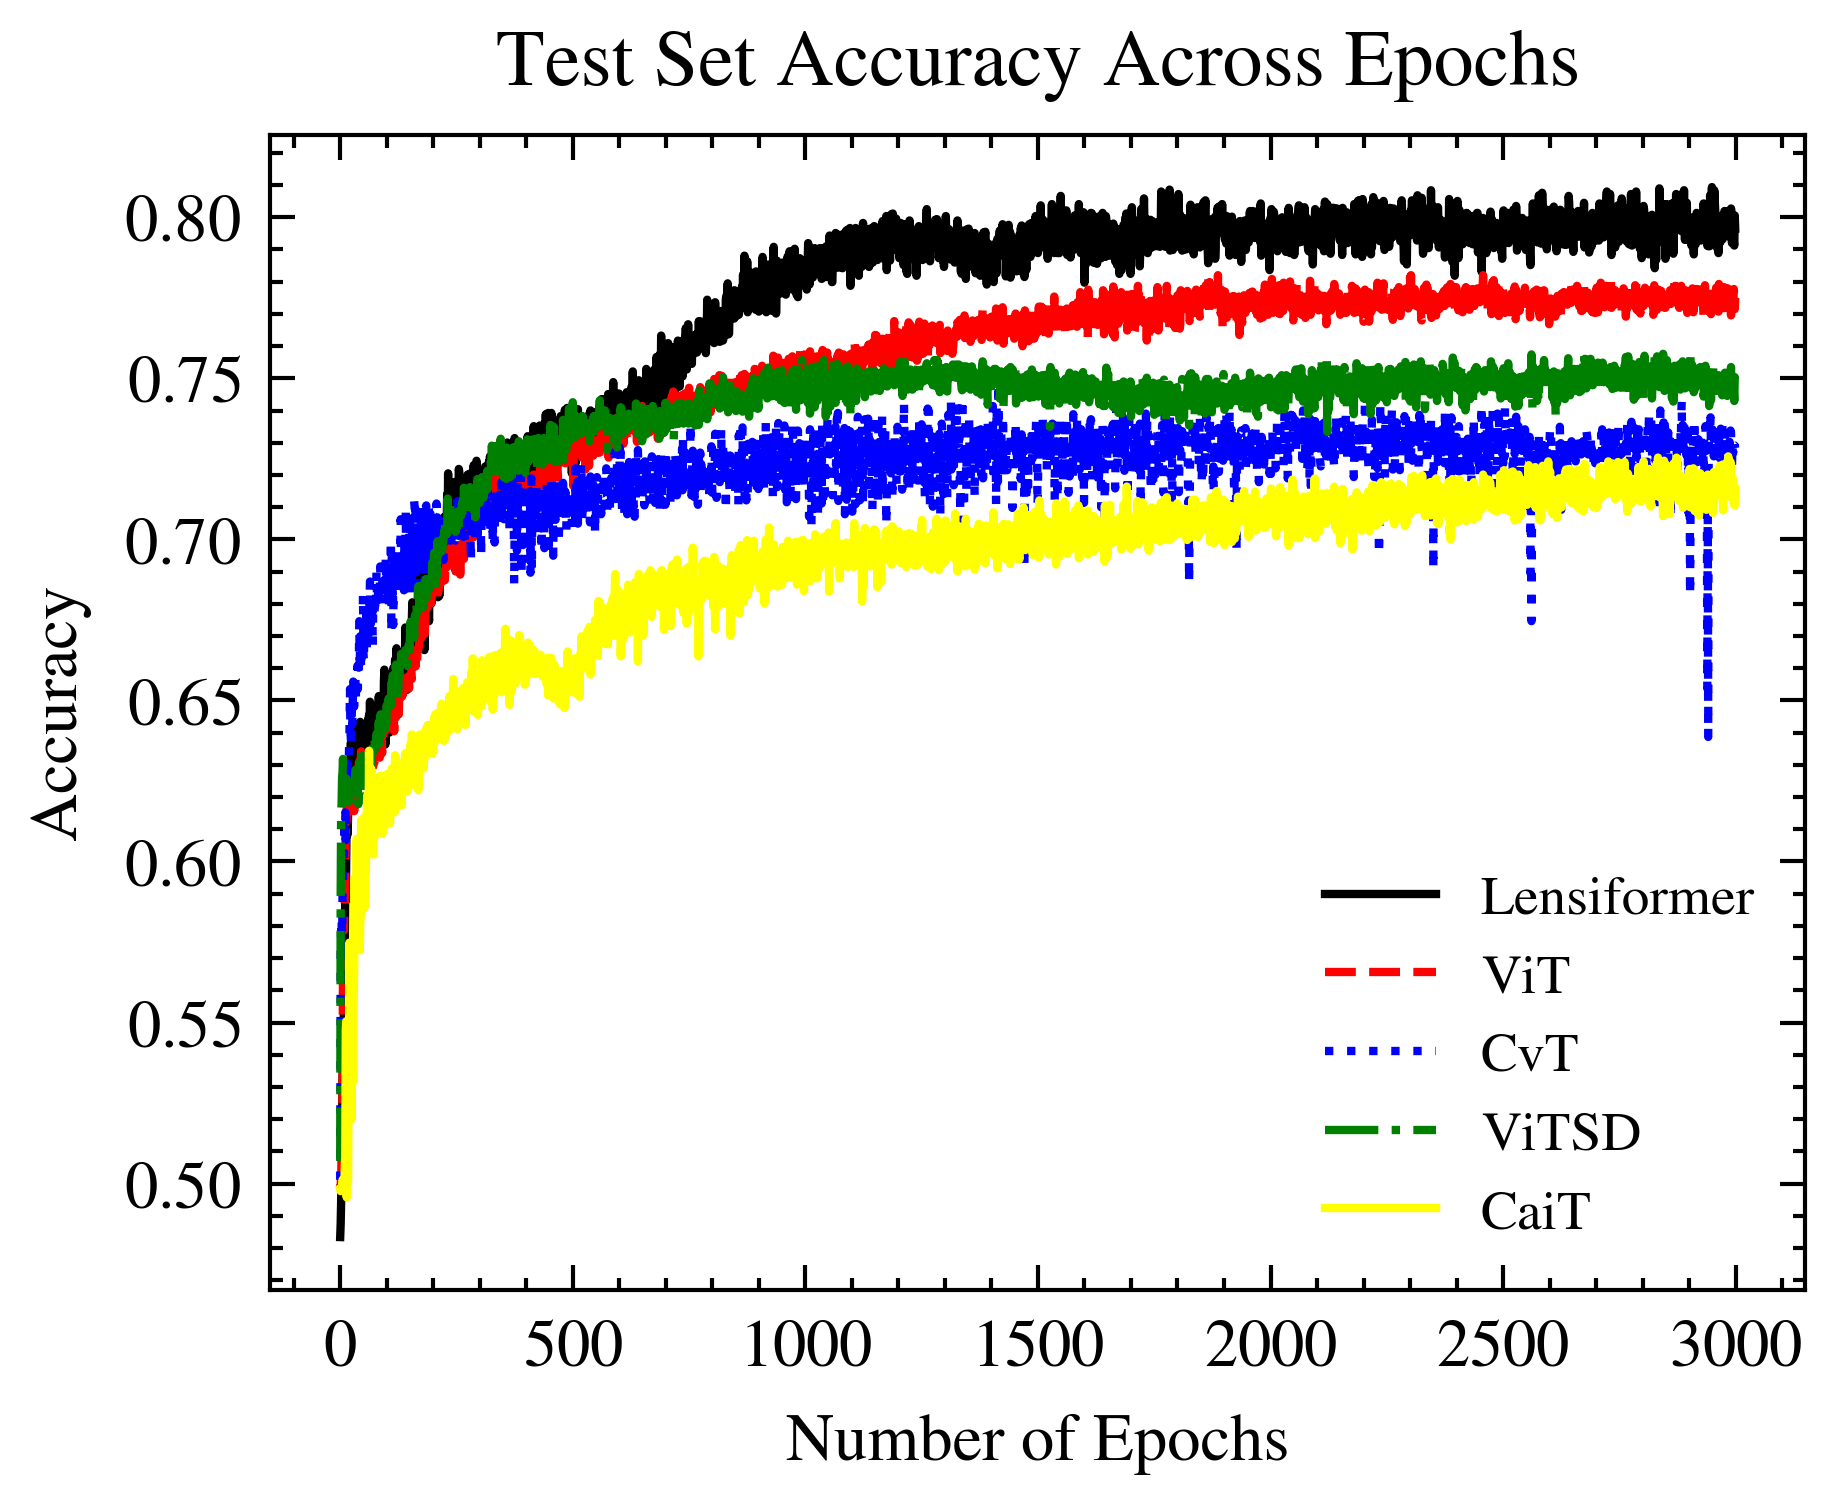

In [94]:
plt.plot(mean_f1_test_lens,label='Lensiformer')
plt.plot(mean_f1_test_vit,label='ViT')
plt.plot(mean_f1_test_cvt,label='CvT')
plt.plot(mean_f1_test_vitsd,label='ViTSD')
plt.plot(mean_f1_test_cait,label='CaiT',color='yellow')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Test Set Accuracy Across Epochs')
plt.legend(fontsize='small')

# Save the plot as an SVG file
plt.savefig('accuracy.svg', format='svg')  # Save the plot in SVG format

# Save the plot as a PNG file
plt.savefig('accuracy.png', format='png')  # Save the plot in PNG format

plt.show()

# Plotting Losss

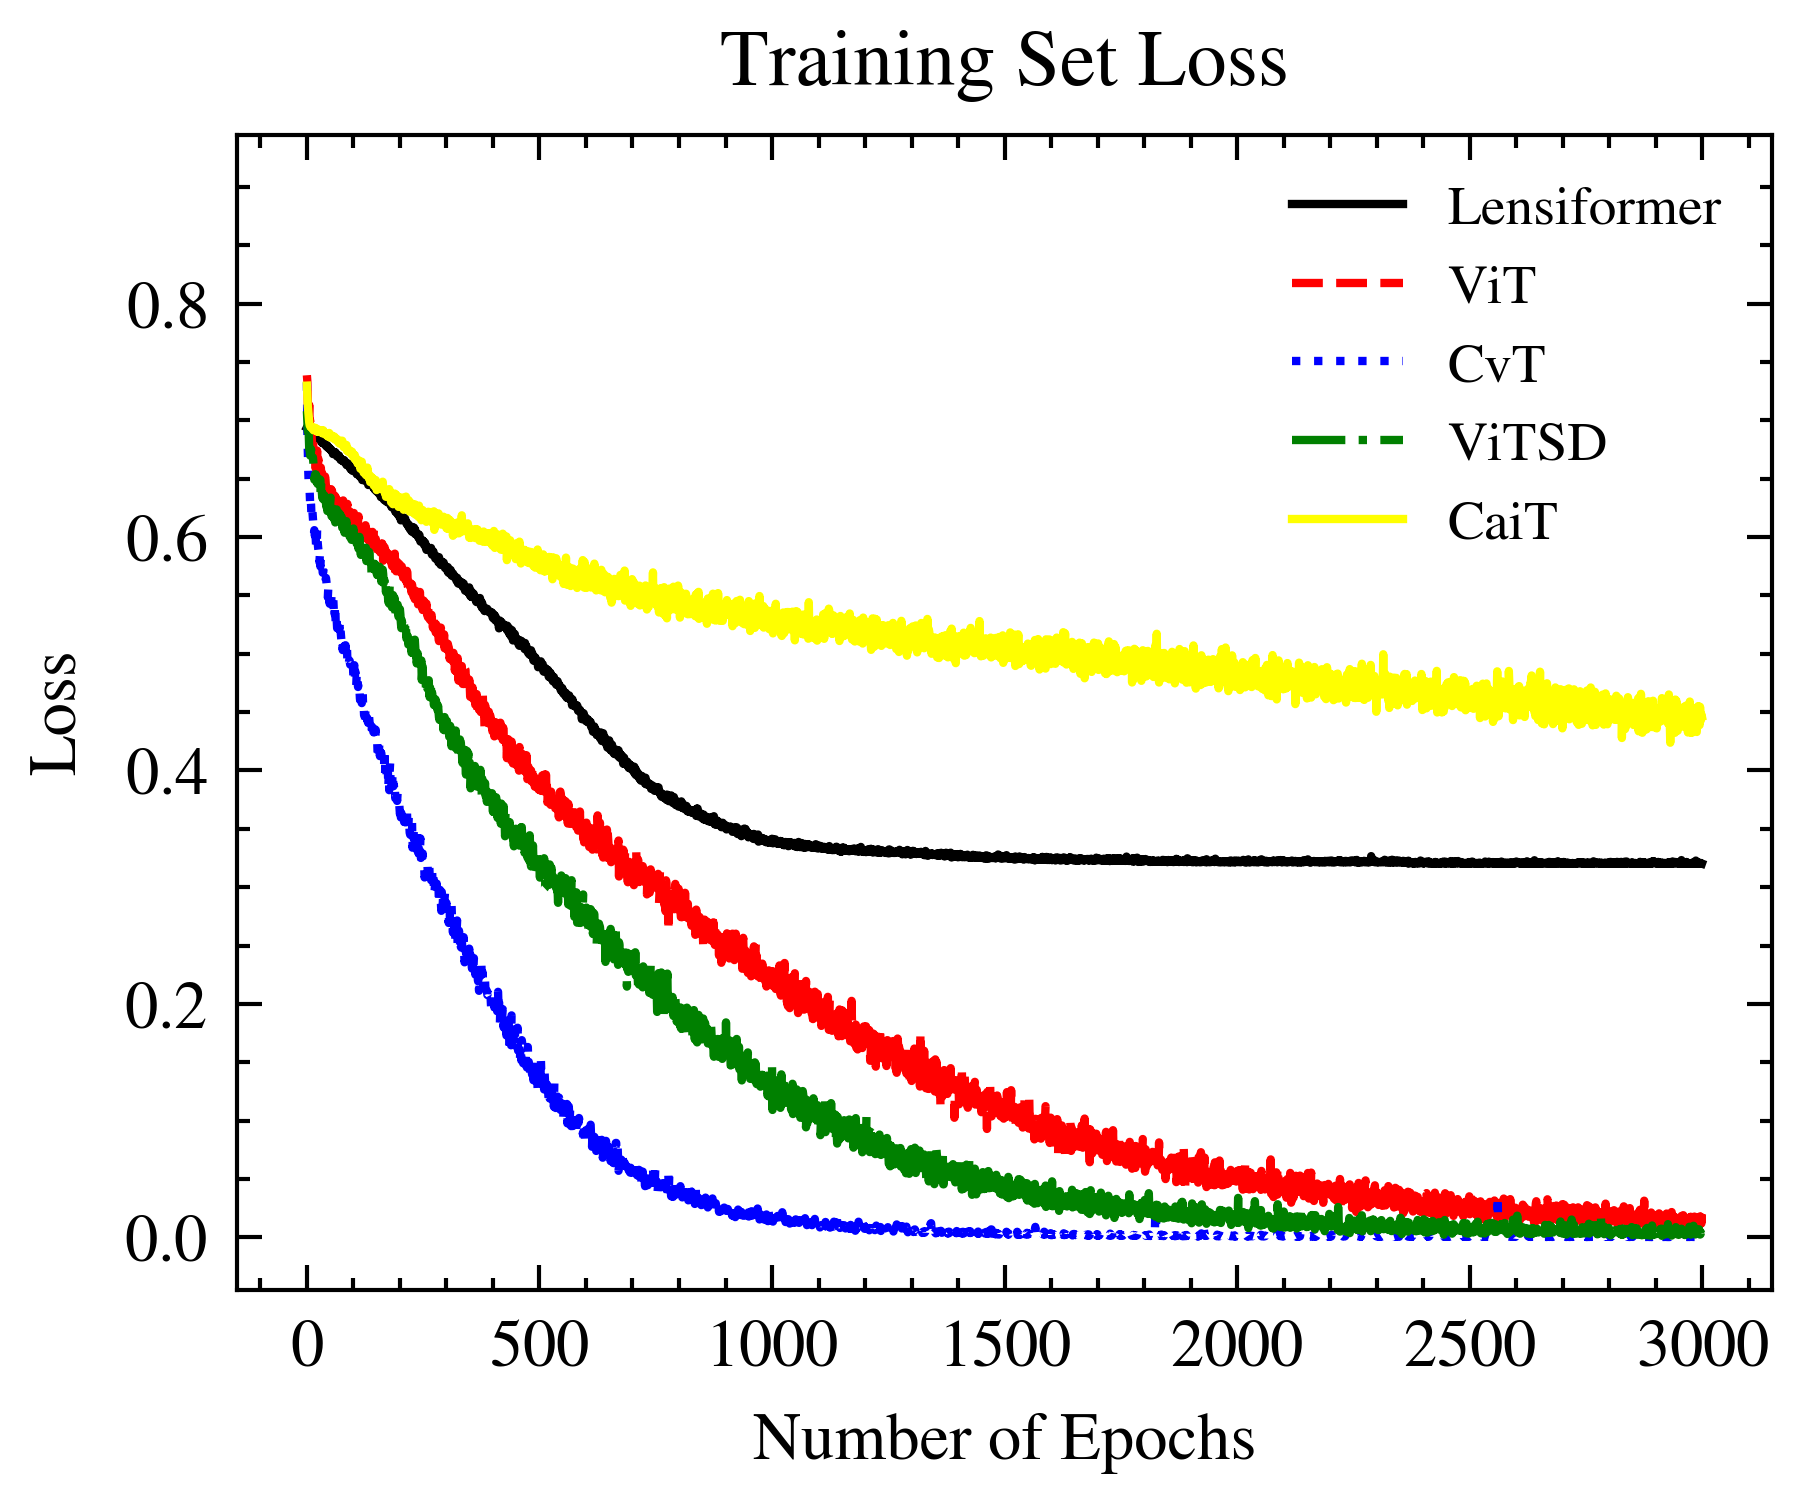

In [95]:
# Create a 1x2 grid of subplots

# Set the global title for the entire figure
plt.title('Model Loss Comparison Across Epochs')

plt.plot([0],[0.9])
plt.plot([0],[0.9])
plt.plot([0],[0.9])
plt.plot([0],[0.9])

# Plot the training set loss on the second subplot
plt.plot(mean_loss_train_lens, label='Lensiformer')
plt.plot(mean_loss_train_vit, label='ViT')
plt.plot(mean_loss_train_cvt, label='CvT')
plt.plot(mean_loss_train_vitsd, label='ViTSD')
plt.plot(mean_loss_train_cait,label='CaiT',color='yellow')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Training Set Loss')
plt.legend(fontsize='small')

# Save the plot as an SVG file
plt.savefig('loss.svg', format='svg')  # Save the plot in SVG format

# Save the plot as a PNG file
plt.savefig('loss.png', format='png')  # Save the plot in PNG format

# Show the plots
plt.show()


## Plotting ROC-AUC Curve

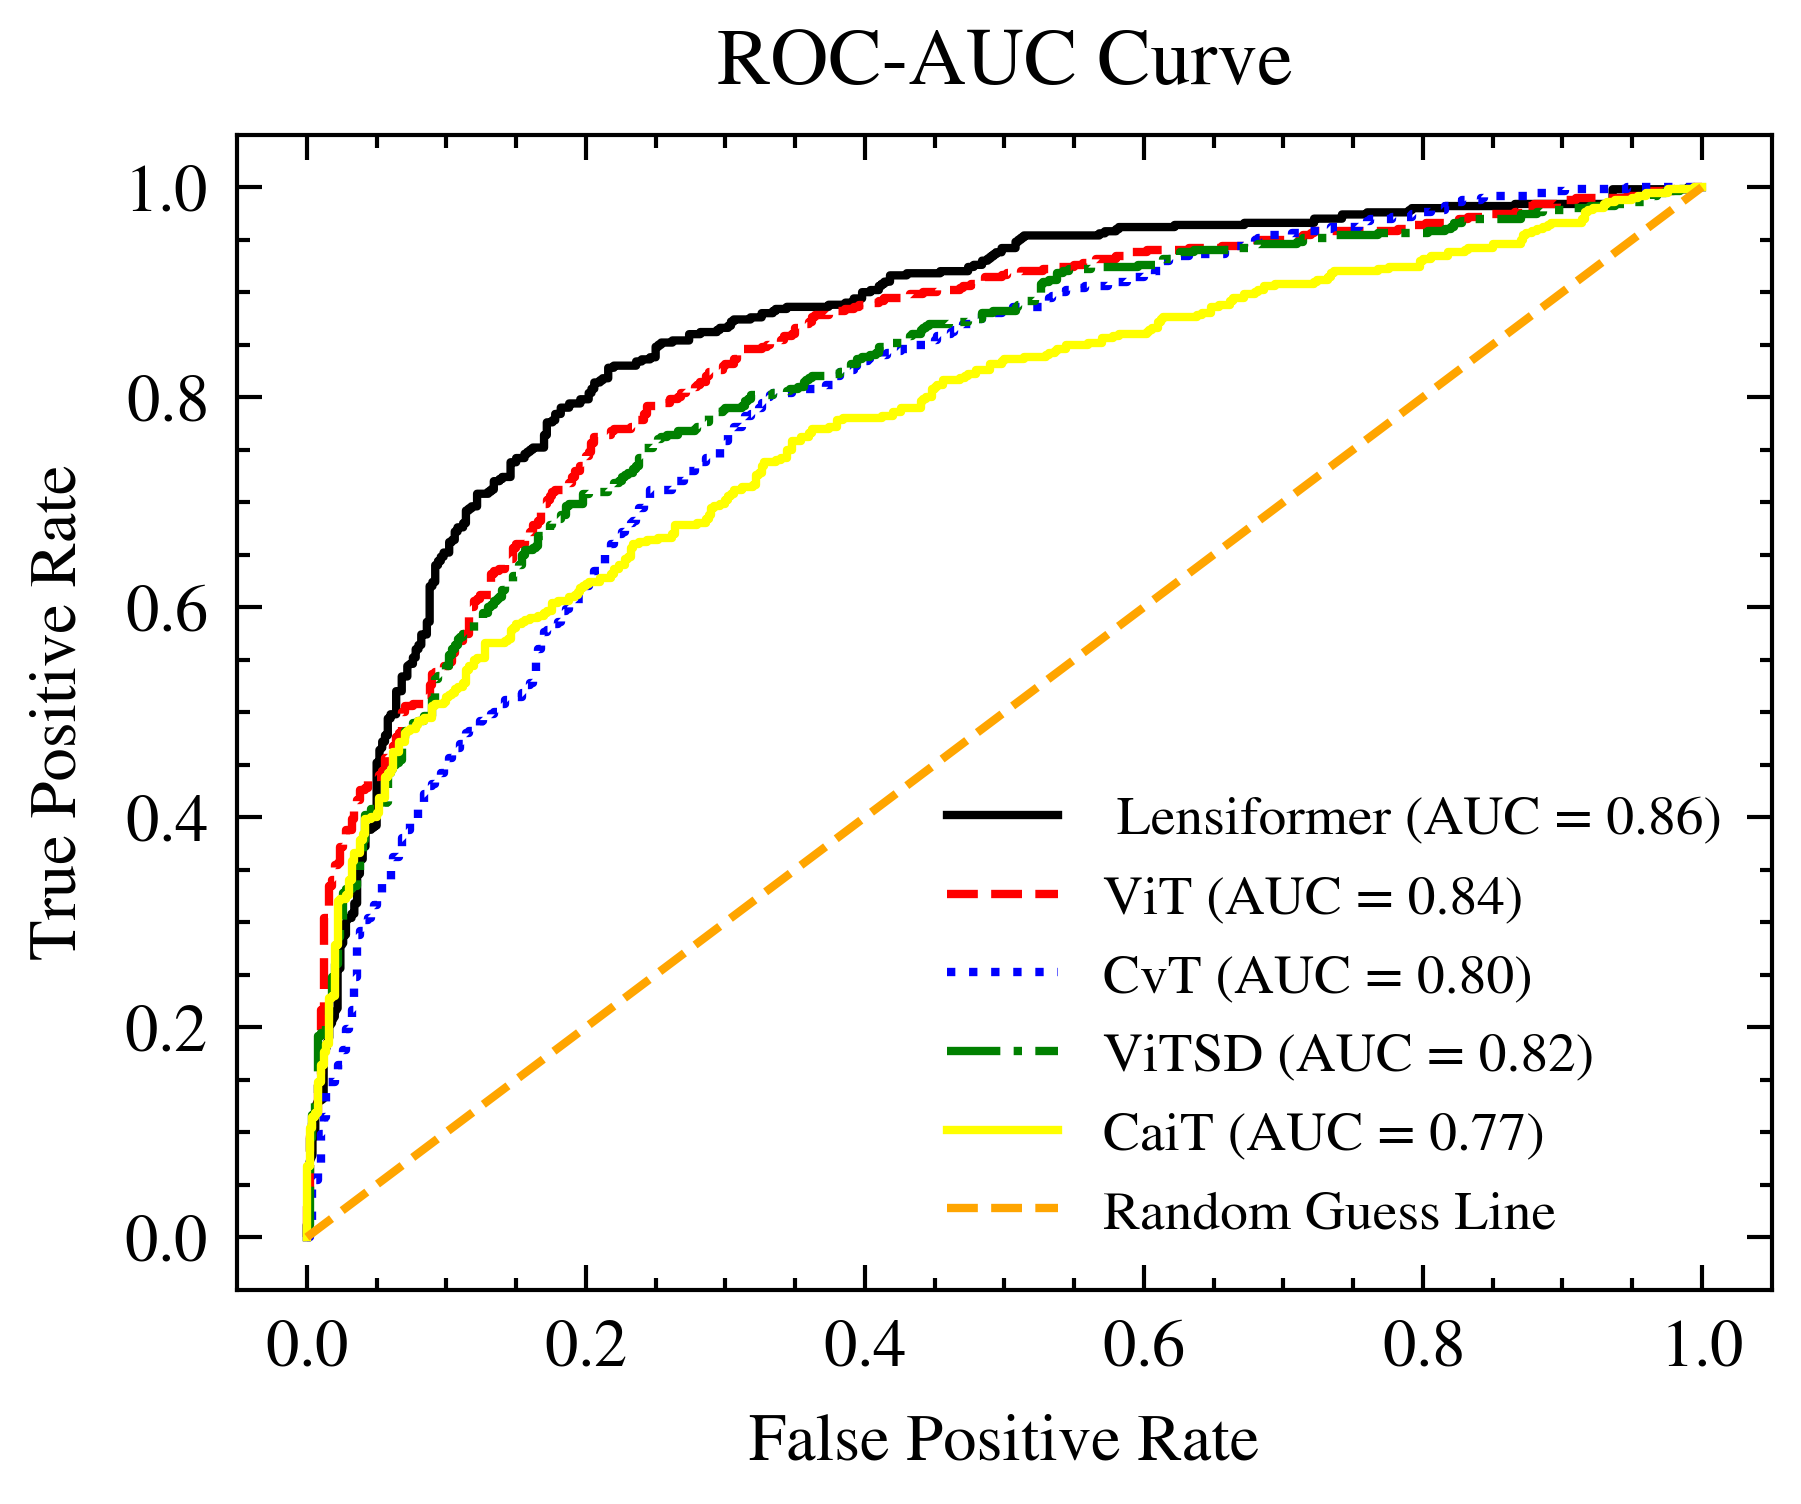

In [101]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch


# Prepare for ROC-AUC curve
final_test_loader = get_loader_from_dataset(X_test, y_test, batch_size=1000)

# for images, target in final_test_loader:
#     images, target = images.to(device), target.to(device)
#     break


for model_name, model in [('Lensiformer', lens),('ViT', vit), ('CvT', cvt),('ViTSD',vitsd),('CaiT', cait)]: # ('CvT', cvt),
    output = model(images)
    y_pred_onehot = output.detach().cpu().numpy()
    y_true_onehot = target.detach().cpu().numpy()

    # Convert one-hot encoding to label format
    y_true = np.argmax(y_true_onehot, axis=1)

    # Get the predicted probabilities for the positive class
    y_pred_prob = y_pred_onehot[:, 1]

    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    if model_name!='Lensiformer' and model_name!='CaiT':
      plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    elif model_name=='CaiT':
      plt.plot(fpr, tpr,color='yellow', label=f'{model_name} (AUC = {roc_auc:.2f})')
    else:
      plt.plot(fpr, tpr, label=f' {model_name} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'--',label='Random Guess Line',color='orange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(fontsize='small')

# Save the plot as an SVG file
plt.savefig('auc.svg', format='svg')  # Save the plot in SVG format

# Save the plot as a PNG file
plt.savefig('auc.png', format='png')  # Save the plot in PNG format

# Show the plot
plt.show()
